In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

import os
os.chdir('./..')
from analysis import *

In [2]:
horses = pd.read_csv('./../data/horses.csv', dtype=horsedtype)
races = pd.read_csv('./../data/races.csv', dtype=racedtype)

horses['date'] = pd.to_datetime(horses['date'])
races['date'] = pd.to_datetime(races['date'])
races['startTime'] = pd.to_datetime(races['startTime'])

In [3]:
horses['placeFin'] = pd.Series([np.nan] * horses.shape[0])
horses['lengthsBackFin'] = pd.Series([np.nan] * horses.shape[0])
for i in reversed(range(1, 7)):
    horses.loc[horses['placeFin'].isnull(),'placeFin'] = horses.loc[horses['placeFin'].isnull(), 'placeSeg' + str(i)]
    horses.loc[horses['lengthsBackFin'].isnull(),'lengthsBackFin'] = horses.loc[horses['lengthsBackFin'].isnull(), 'rlLengthsSeg' + str(i)]

horses.loc[horses['placeFin'] == 1, 'lengthsBackFin'] = 0

horses = horses.sort_values(by=['date', 'track', 'race', 'odds'])
horses = flagNew(horses, flagColName='newRace', cols=['date', 'track', 'race'])
horses = iterateFlagNew(horses, flagColName='newRace', iterateColName='oddsRank').sort_index()
horses['probability'] = 1 / (horses['odds'] + 1)

horses = pd.merge(horses, horses[['track','date','race','lengthsBackFin']].groupby(['track','date','race']).mean().rename(columns={'lengthsBackFin':'avgLengthsBack'}), on=['track', 'date', 'race'])
horses['diffFromAvg'] = horses['avgLengthsBack'] - horses['lengthsBackFin']

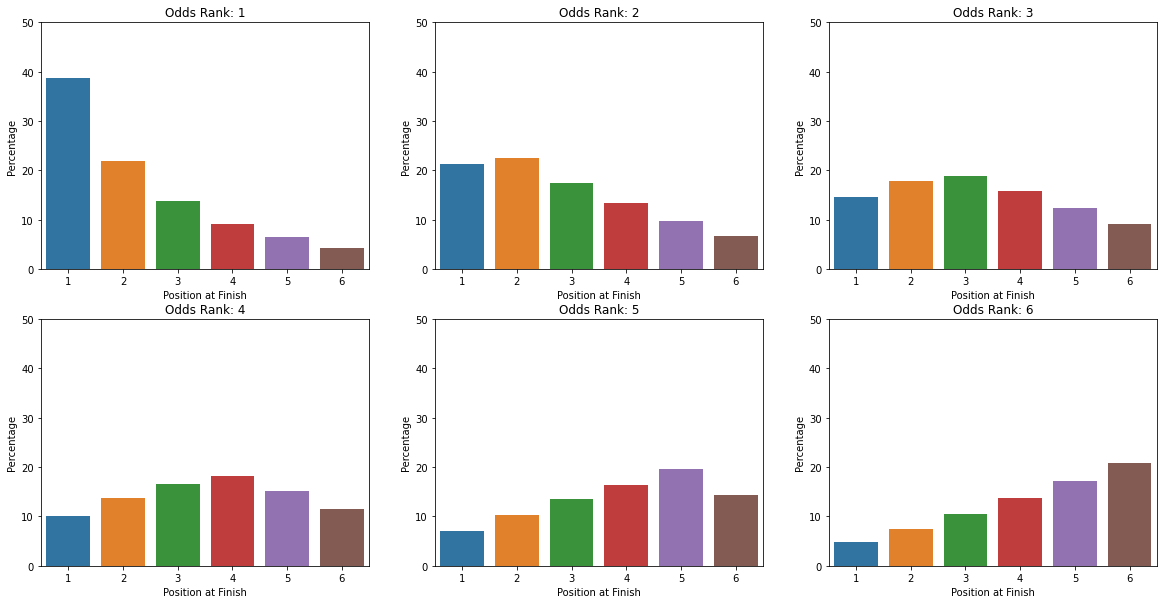

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
plotCoords = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]
for i in range(1, 7):
    subset = horses.loc[horses['oddsRank'] == i, ['placeFin', 'race']]
    group = subset.groupby('placeFin').count()
    group['percent'] = group['race'] / group['race'].sum() * 100

    sns.barplot(x=list(range(1,7)), y=group['percent'][:6], ax=axs[plotCoords[i - 1][0], plotCoords[i - 1][1]])
    axs[plotCoords[i - 1][0], plotCoords[i - 1][1]].set_xlabel('Position at Finish')
    axs[plotCoords[i - 1][0], plotCoords[i - 1][1]].set_ylabel('Percentage')
    axs[plotCoords[i - 1][0], plotCoords[i - 1][1]].set_title('Odds Rank: ' + str(i))
    axs[plotCoords[i - 1][0], plotCoords[i - 1][1]].set_ybound((0, 50))

Text(0.5, 0, 'Odds')

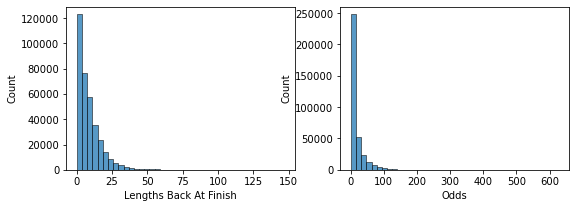

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(horses['lengthsBackFin'], bins=40, ax=axs[0])
axs[0].set_xlabel('Lengths Back At Finish')
sns.histplot(horses['odds'], bins=40, ax=axs[1])
axs[1].set_xlabel('Odds')

Text(0.5, 0, 'Odds Rank')

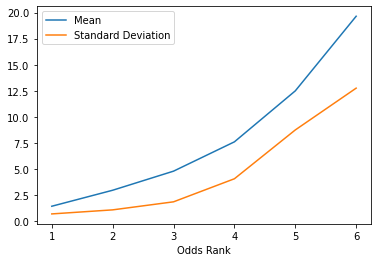

In [6]:
means = []
stds = []
for rank in range(1, 7):
    oddsSubset = horses.loc[horses['oddsRank'] == rank, :]
    means.append(oddsSubset['odds'].mean())
    stds.append(oddsSubset['odds'].std())

sns.lineplot(x=list(range(1, 7)), y=means, label='Mean')
sns.lineplot(x=list(range(1, 7)), y=stds, label='Standard Deviation')
plt.legend()
plt.xlabel('Odds Rank')

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
sns.histplot(horses['diffFromAvg'], bins=40, ax=axs[0])
axs[0].set_xlabel('Difference From Average Finish')
sns.histplot(np.power(horses['odds'], 0.125), bins=40, ax=axs[1])
axs[1].set_xlabel('Odds ^ 0.125')
sns.regplot(data=samp,x='transformedOdds',y='diffFromAvg', line_kws={'color': 'red'}, ax=axs[2])
axs[2].set_xlabel('Odds ^ 0.125')
axs[2].set_ylabel('Difference From Average Finish')

NameError: name 'samp' is not defined

In [8]:
modelFit = smf.ols("diffFromAvg ~ transformedOdds", data=samp).fit()

In [9]:
modelFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diffFromAvg   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     1188.
Date:                Sat, 10 Jul 2021   Prob (F-statistic):          1.21e-233
Time:                        17:11:26   Log-Likelihood:                -16916.
No. Observations:                4964   AIC:                         3.384e+04
Df Residuals:                    4962   BIC:                         3.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          23.3314      0.688     33.898      0.000      21.982      24.681
transformedOdds   -17.8675      0.518    -34.472      0.000     -18.884     -16.851
==============================================================================
Omnibus:                     2129.354   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21313.071
Skew:                          -1.777   Prob(JB):                         0.00
Kurtosis:                      12.508   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
testOdds = [1,2,3,4,5,6,7,8,9,10,15,20,30,50]
finishLengths = []
for i in testOdds:
    transed = i ** 0.125
    finishLengths.append(modelFit.params.Intercept + modelFit.params.transformedOdds * transed)

Text(0, 0.5, 'Length Difference From Average')

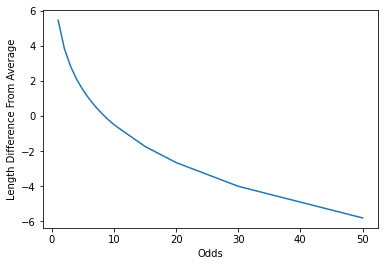

In [24]:
sns.lineplot(x=testOdds, y=finishLengths)
plt.xlabel('Odds')
plt.ylabel('Length Difference From Average')